# CNNs - Rapper's Features

In this notebook 
* I outline CNNs including the dimensionality arithmetic. 
* I impliment a low-level feature extractor calle dthe sobel operator, which is used to detect edges on an image. 
* I pre-load the VGG-19 model ([Simonyan & Zisserman 2015](#Simonyan15)), which is available to load as a pre-trained model in the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module. This CNN model has been pre-trained on the [ImageNet](http://www.image-net.org) dataset, which is a large scale image classification dataset which to date has over 20,000 categories and over 14 million images. Large deep learning models trained on this dataset tend to learn general, useful representations of image features that can be used for a range of image processing tasks. I will use it to extract convolutional layer outputs, so that I can see how the vgg model is using the features its learnt
* I will impliment my own Saliency Mapping

### Recap of dimensionality Arithmetic

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D

#create a Basic CNN to understand the dimensionality arithemtic

model = Sequential([
    # 2D convolutional Layer, with number of filters=8 (this is specifying the output channel dim), kernal =(3,5)
    Conv2D(8, (3,5), activation='relu', input_shape=(32,32,3)),
    # spat out: (32-3+1=30, 32-5+1=28, 8)
    
    #Maxpooling layer, with a (2,2) poolarea (for each 2x2 block in input it takes the max of those 4 values)
    #halves spatial dims (channel dim not effected as pooling is done channel-wise)
    MaxPool2D((2,2)),
    #spat out: (30/2=15, 28/2=14, 8)
    
    #2D convolutional layer, with 16 filters (output channel) and (3,3) kernal
    Conv2D(16, 3, activation='relu'),
    #spat out: (15-3+1=13, 14-3+1=12, 16)
    
    #maxpool layer with (2,2) pool area. note since the inputs height dim is odd (and no padding (VALID)) tf will drop
    #bottom (13th) row 
    MaxPool2D(2)
    #spat out: (floor(13/2)=6, 12/2=6, 16)
])


In [3]:
#lets confirm dimension expections
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 28, 8)         368       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
Total params: 1,536
Trainable params: 1,536
Non-trainable params: 0
_________________________________________________________________


Lets have a look at our layer kernal and biases! Recall the convolutional layer 'operation':

$$
\mathbf{h}^{(k)} = \sigma\left((\mathbf{h}^{(k-1)} * \mathbf{k}^{(k-1)}) + \mathbf{b}^{(k-1)}\right),\label{convlayer_multichannel}\tag{3}
$$


In [4]:
from pprint import pprint
pprint(model.layers)

In [5]:
first_layer = model.layers[0]

#expect first 2DConvo layer to be rank-4 tensor: (height, width, input_channel, output_channel) = (3, 5, 3, 8) 
print(first_layer.kernel.shape)
#expect our bias to be rank-1 tensor: (output_channel,) =(8,)
print(first_layer.bias.shape)

(3, 5, 3, 8)
(8,)


### Sobel Operator - Edge Detection

The kernels (or filters) in CNNs are typically learned with backpropagation. However, simple low-level features such as edge detection kernels can also be designed by hand. I am going to set the kernal weights of a model to the sobel operator which is a simple and intuitive edge detection kernel. See [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more details!

In [6]:
# create a super simple model for illistration purposes

model = Sequential([
    #2D convolutional layer, I am setting the input_shape to (None, None, 1) because I want the flexibility of sending it any
    #greyscale img size. Using None in a dim, tells tf that dim is not fixed for each example we send our model, its variable
    # setting a (3,3) kernal with output dim=1 (greyscale) and no bias will be added to the convolution!
    
    Conv2D(1, (3,3), use_bias=False, input_shape=(None,None,1)), 
])

In [7]:
model.weights

[<tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
 array([[[[-0.15469497]],
 
         [[ 0.4717127 ]],
 
         [[-0.53815705]]],
 
 
        [[[ 0.17252988]],
 
         [[-0.42694682]],
 
         [[-0.36590067]]],
 
 
        [[[ 0.3132    ]],
 
         [[ 0.53103423]],
 
         [[-0.49278587]]]], dtype=float32)>]

In [8]:
# idea is to replace these weights with the sobel kernals and send an img through the model with these kernal set!


#Sobel operator is made up of two kernals. One in the x dirn one in the y dirn - both measure changes in pixel intensity

sobel_x = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=tf.float32, name='SOBEL_X')
sobel_y = tf.constant ([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32, name='SOBEL_Y')

print(sobel_x, end=2*'\n')
print(sobel_y)


tf.Tensor(
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]], shape=(3, 3), dtype=float32)

tf.Tensor(
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]], shape=(3, 3), dtype=float32)


In [9]:
# Set the model kernel

#def a function that assigns the values of the kernal vairable in our model to one of the sobel kernals 

def assign_filter(arr):
    #note kernal is rank-4 tensor! so need to add extra dims!
    model.weights[0].assign(arr[... ,tf.newaxis, tf.newaxis]) 
    

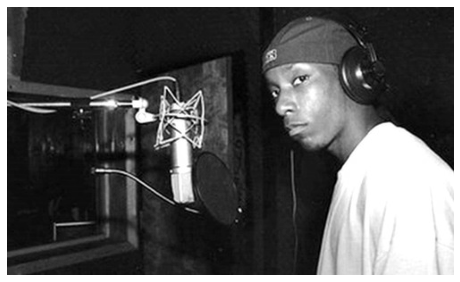

In [10]:
# Load an image as grayscale 

import matplotlib.pyplot as plt

image = tf.io.read_file("./figures/big_l.jpg")
image = tf.io.decode_png(image, channels=1) # converts to a tensor
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [11]:
#lets assign SOBEL_X first 

print('before_X', model.weights[0])
assign_filter(sobel_x)
print('after_X', model.weights[0], end=4*'\n')

before_X <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
array([[[[-0.15469497]],

        [[ 0.4717127 ]],

        [[-0.53815705]]],


       [[[ 0.17252988]],

        [[-0.42694682]],

        [[-0.36590067]]],


       [[[ 0.3132    ]],

        [[ 0.53103423]],

        [[-0.49278587]]]], dtype=float32)>
after_X <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
array([[[[ 1.]],

        [[ 0.]],

        [[-1.]]],


       [[[ 2.]],

        [[ 0.]],

        [[-2.]]],


       [[[ 1.]],

        [[ 0.]],

        [[-1.]]]], dtype=float32)>





In [12]:
#send our image through the model - first with sobel_x assigned as kernal, then sobel_y. Finally take the modulus!

#NOTE: model requires a input = (batch_dim, input_shape). our img is (input_shape, channel_dims) so need to add a new first
# dim to act as the batch dim!

#sobel_x - already been assigned in previus cell
gx = model(tf.expand_dims(image, axis=0))

print('image dim: see no batch_dim', image.shape)
print('img with batch_dim added', tf.expand_dims(image, axis=0).shape)

#sobel_y
assign_filter(sobel_y)
gy = model(tf.expand_dims(image, axis=0))

#take modulus
g = tf.sqrt(tf.square(gx) + tf.square(gy))

image dim: see no batch_dim (300, 500, 1)
img with batch_dim added (1, 300, 500, 1)


(-0.5, 497.5, 297.5, -0.5)

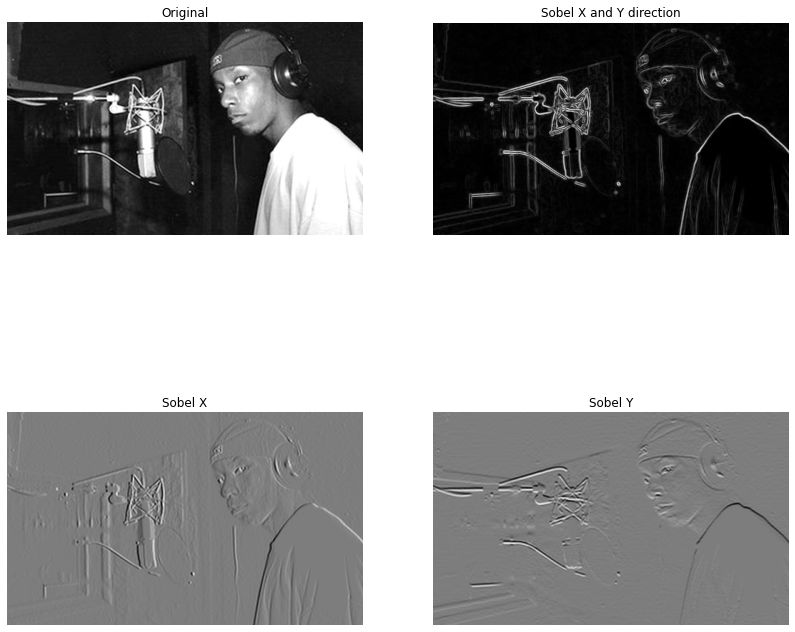

In [13]:
fig, axs = plt.subplots(2,2, figsize=(14, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

axs[0,0].imshow(image, cmap='gray')
axs[0,0].set_title('Original')
axs[0,0].axis('off')

axs[0,1].imshow(tf.squeeze(g, axis=0), cmap='gray')
axs[0,1].set_title('Sobel X and Y direction')
axs[0,1].axis('off')

axs[1,0].imshow(tf.squeeze(gx, axis=0), cmap='gray')
axs[1,0].set_title('Sobel X')
axs[1,0].axis('off')

axs[1,1].imshow(tf.squeeze(gy, axis=0), cmap='gray')
axs[1,1].set_title('Sobel Y')
axs[1,1].axis('off')

Intresting to notice how when we scan in the x direction (using Sobel X) we are picking up Big L's creases in his shirt, as these are vertical lines, whereas when we are scaning vertically (using Sobel Y), we dont pick up the creases (because they are vertical!)

So I have implimented a simple (hand-crafted) feature extractor and we can see it results in a feature map which provides
useful infomation about the image. In CNN models the parameters of filters like these are **learned** during training so that 
they can pick out whatever features are useful for the task at hand 

## Pre Trained VGG-19 Model for Img Classification

This model has a specific CNN arictiture, called a VGG (Visual Geometry Group) architecture. The 19 represents the number of convolutional and dense layers in the model. This model has been pre-trained on the [ImageNet](http://www.image-net.org) dataset and we are loading the weights that have resulted from that training!

In [14]:
# Load the VGG-19 model

vgg_original = tf.keras.applications.VGG19(weights='imagenet')

In [15]:
# Large model with almost 150 million parameters!
vgg_original.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Summary of model: 5 blocks the first two has two Convolutional 2D layers then a max pooling and the other three have four Convolutional Layers with max_pooling. all max pooling have (2,2) dims (halving)! Finally there is a flatten layer which flattens the final max_pooling output (7, 7, 512) in on long rank-1 tensor (25088). This is followed by a couple of full connected dense layers and the final dense layer outputs a rank-1 tensor of length 1000 - which correspnds to a probability of being in each of the 1000 categories (softMax activation used)!

**Important** - The VGG-19 model requires that the input is (244, 244, 3) (FIXED) 244=pixels and 3=colour channels (rbg)! However this can be changed by the keyword argument `include_top = False`. This mean I can then feed in any image, as the model expects the dims to be variable but with 3 channels RGB: (None, None, None, 3). **This will remove the final Dense Layers** as we are no longer looking to classify the Image. If we were I pretty sure we can put any img in just as long as we do the pre-processing on the img before sending it through thwe model! 

In [16]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

In [17]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

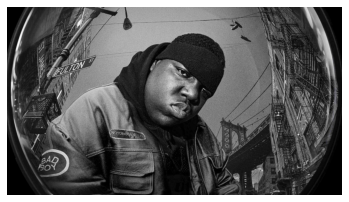

In [27]:
# Load a colour image

image = tf.io.read_file("./figures/biggie.jpg")
image = tf.io.decode_jpeg(image, channels=3)
plt.figure(figsize=(6, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

I will define a functional multi-output model to 'hack' into the Vgg model and pull out convolutional layer outputs, so that I can see how the vgg model is using the features its learnt (on its training data - remember I have pre-loaded these features) to work out what it is seeing!

In [28]:
from tensorflow.keras.models import Model

#use the vgg.inputs method (which stores the dims of the inputs to vgg model (None, None, None, 3))
inputs = vgg.inputs 
# extract outputs from several layers - we can do this by their str name rather than indexing 
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
#ouput of layers are stored in list
outputs = [vgg.get_layer(layer_name).output for layer_name in layer_names]

#so single input and 5=outputs of our model
# Note that: both inputs/outputs are called over the vgg model hence we can think of our model as built on vgg
vgg_features = Model(inputs=inputs, outputs=outputs) 

In [29]:
# View the model inputs and outputs Tensors
from pprint import pprint 

pprint(vgg_features.inputs)
print('')
pprint(vgg_features.outputs)

[<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>]

[<tf.Tensor 'block1_conv2/Relu_1:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2/Relu_1:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv4/Relu_1:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block4_conv4/Relu_1:0' shape=(None, None, None, 512) dtype=float32>,
 <tf.Tensor 'block5_conv4/Relu_1:0' shape=(None, None, None, 512) dtype=float32>]


In [30]:
# VGG Model requires specific pre-proccessing of img before sending it into model - has its own method!
image_processed = tf.keras.applications.vgg19.preprocess_input(image)

In [31]:
#the output features will be given by our vgg_features model called on this porcessed image - REMEMBER BAYCH DIM
features = vgg_features(image_processed[tf.newaxis,...])

In [32]:
#I also want to compare these layer outputs to the orginal image
# so lets add it to the list 

features = [image] + features

In [33]:
print(features[2].shape)

(1, 365, 650, 128)


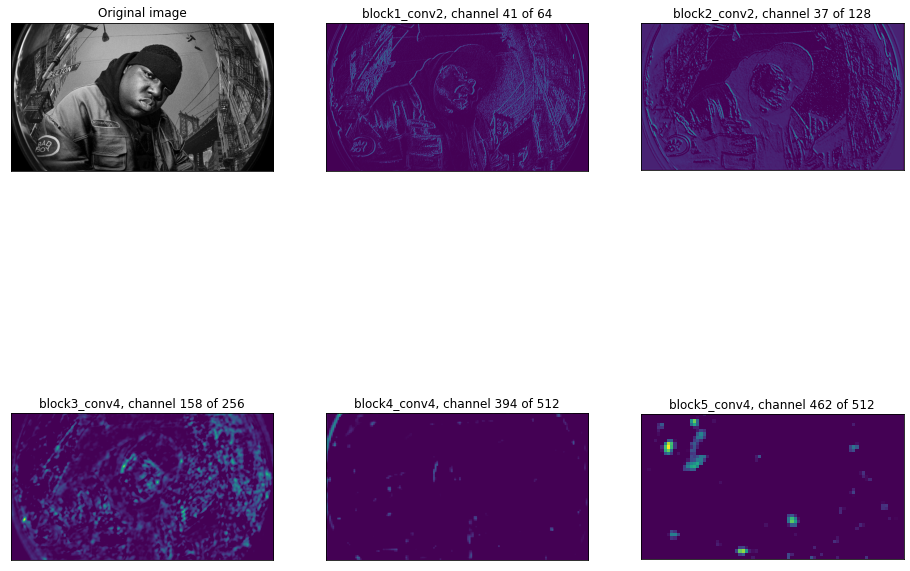

In [39]:
# Visualise the features

import numpy as np

n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features)):
    feature_map = features[i]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    #plot original img
    if i == 0:
        axes[row, col].imshow(image)
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

This visually shows how as we move through the layers of the network the features the layer "looks" for become more and more abstract! The first layer is looking for edges, then the next two focus on textures, but then after that the features are becoming abstract. 

[10 CNN Architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d) - Look into these and play around!

## Saliency Mapping

I will use a VGG16 convolutional neural network (CNN) that has been pre-trained on the ImageNet dataset. The VGG network is an important CNN architecture that was developed by the [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/) at the University of Oxford. 

* Simonyan, K. & Zisserman, A. (2015), "Very Deep Convolutional Networks for Large-Scale Image Recognition", *International Conference on Learning Representations (ICLR)*, San Diego, CA, USA, May 7-9, 2015.

Saliency maps are an important general concept in computer vision that refer to a group of techniques for **highlighting** specific features in an image (such as the **pixels**) that are the most conspicous (or salient) **in relation to some property of the image** (typically summarised as a scalar value). For example, consider how colour images can be converted to black-and-white to analyse colour intensity, or how night vision can be used to detect light sources.

In the context of deep learning models, saliency maps have been used as a means to make network predictions more interpretable. They can be used to analyse the sensitivity of network predictions to pixels in the input. In other words, they highlight which pixels affect the network prediction the most - the underlying assumption being that such pixels will most likely correspond to the object being classified.

My goal is to use a convolutional neural network pre-trained on the ImageNet dataset, to compute saliency maps that analyse the sensitivity of network predictions to pixels in the input. The saliency map should be computed by calculating the gradient of the model's top-scoring logit prediction with respect to the input image.

In [1]:
#dependencies
import tensorflow as tf
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#get VGG16 model - want logits(no activation) not softmax activation (which allows for prob interp)

vgg16 = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', classifier_activation=None)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

I will use a random sample of 1% of the images from the validation set of the ImageNet dataset, which I have stored in `"./data/images"`. ImageNet classification dataset is organised according to the WordNet hierarchy. Labels in ImageNet are organised in 'synsets' (synonym sets), consisting of multiple words or phrases.

In [3]:
# Load the label data

def load_json(path):
    with open(path, 'r') as json_file:
        j = json.load(json_file)
    return j

labels = load_json('./data/labels.json')
synsets = load_json('./data/synsets.json')
synset_words = load_json('./data/synset_words.json')

In [4]:
# Get a list of image file paths

img_folder = './data/images'
img_list = os.listdir(img_folder)
img_filepaths = [os.path.join(img_folder, f) for f in img_list]

#just had to replace \\ with / 
img_filepaths = [img_.replace("\\", "/") for img_ in img_filepaths]

In [5]:
img_filepaths[0:3]

['./data/images/ILSVRC2012_val_00000156.JPEG',
 './data/images/ILSVRC2012_val_00000192.JPEG',
 './data/images/ILSVRC2012_val_00000305.JPEG']

filename: ILSVRC2012_val_00043117.JPEG
image label: leopard, Panthera pardus
image shape: (257, 384, 3)


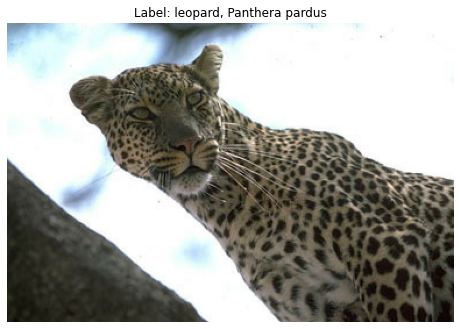

In [6]:
# View a sample image and label

def sample_random_image_and_label():
    i = np.random.choice(len(img_filepaths))
    img_filepath = img_filepaths[i]
    filename = img_filepath.split('/')[-1]
    print('filename:', filename)
    
    #retrive label, find synset and then find word!
    label_inx = labels[filename]
    synset = synsets[label_inx]
    words_label = synset_words[synset]
    print('image label:', words_label)
    return img_filepath, words_label

img_file, label = sample_random_image_and_label()
raw_img = tf.io.read_file(img_file)
img_tensor = tf.io.decode_jpeg(raw_img, channels=3)

plt.figure(figsize=(8, 6))
plt.imshow(img_tensor.numpy())
print('image shape:', img_tensor.shape)
plt.axis('off')
plt.title("Label: {}".format(label))
plt.show()

As can be seen from the model summary, the VGG16 model expects an input image with shape `(224, 224, 3)`. However, the images in the dataset come in varying sizes, as can be seen from the sample above. 

In [7]:
#reshape images!

def load_and_resize_image(filepath, shape):
    """
    This function should load an image from file, and resize it
    """
    raw_img = tf.io.read_file(filepath)
    img_tensor = tf.io.decode_jpeg(raw_img, channels=3)
    
    #resize
    img_tensor = tf.image.resize(img_tensor, size=shape[0:2]) # dont want channel dims of shape! - 
                                                              #tf.image.resizeheight and width
    return img_tensor

In [8]:
#example

resized_img = load_and_resize_image(img_file, (224, 224, 3))
resized_img.shape

#now have our image in the right shape!

TensorShape([224, 224, 3])

In [9]:
def get_model_predictions(vgg16, resized_img):
    """
    This function should process a resized image and compute model predictions.
    
    Returns a tuple of 2 elements (preds, decoded_predictions), where preds
    is the model logit predictions, and decoded_predictions are the decoded top 3 predictions.
    """
    #apply the preproccesing to our resized img
    preprocced_img = tf.keras.applications.vgg16.preprocess_input(resized_img)
    
    #compute the predictions from our model  on this resized img
    preds = vgg16(tf.expand_dims(resized_img, axis=0)) # add a batch dim- used processed_img[tf.newaxis, ...] intead
    
    #vgg16 comes with a method to decode the predictions which is nice!
    #we want to take top three logits (ones with the highest value)
    top_3_list = tf.keras.applications.vgg16.decode_predictions(preds.numpy(), top=3)
    return (preds, top_3_list)

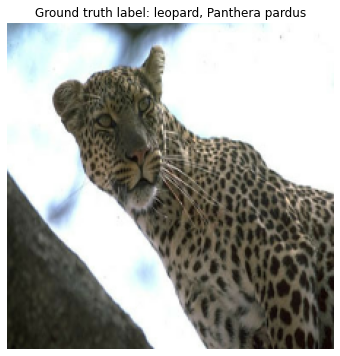

Model predictions:
[[('n02128385', 'leopard', 15.633688), ('n02124075', 'Egyptian_cat', 13.920521), ('n02130308', 'cheetah', 11.762303)]]


In [10]:
# example

#already got our random img and label and resize the img to the required dims for VGG16

#calculate the predictions- both raw and decoded
preds, decoded_preds = get_model_predictions(vgg16, resized_img)

# View the image, ground truth label and model predictions
plt.figure(figsize=(8, 6))
plt.imshow(resized_img.numpy()/ 255. )
plt.axis('off')
plt.title("Ground truth label: {}".format(label))
plt.show()

print("Model predictions:\n{}".format(decoded_preds))

Model predictions are in format: `(synset_code, word_label, logit)`.

Now to impliment the saliency Map. Saliency refers to unique features (pixels, resolution etc.) of the image in the context of visual processing. These unique features depict the visually alluring locations in an image. Saliency map is a topographical representation of them! **Saliency maps process images to differentiate visual features in images.** Classic examples include infrared to detect temperature (red colour is hot and blue is cold) and night vision to detect light sources (green is bright and black is dark). 

Here I will do **Pixel attribution** which is a special case of feature attribution, but for images. Feature attribution explains individual predictions by attributing each input feature according to how much it changed the prediction (negatively or positively), Here the features are pixels! 

The saliency map should be computed by calculating the gradient of the model's top-scoring logit prediction with respect to the input image. To display the saliency map, the function should take the maximum absolute value of the gradient over the channel dimensions at each spatial location!

In [11]:
def saliency_map(vgg16, resized_img, get_model_predictions=get_model_predictions):
    """
    This function should compute the saliency map 
    It should return the tuple (saliency_map, decoded_predictions).
    """
    #since we are looking at gradients - we need to encompass our calculations using gradientTape
    with tf.GradientTape() as tape:
        #we need to track resized img - remember since tf.constant (its not tracked automatically)
        tape.watch(resized_img)
        #get predictions
        preds, decoded_preds = get_model_predictions(vgg16, resized_img)
        
        #preds is a rank-2 tensor (1, 1000) - each elm represent the logit (un-normalised output of the model) for each
        #category - we want the logit with the max! first reduce dim to get vector (rank-1 tensor)
        preds = tf.squeeze(preds)
        
        #find the index of largest logit using argmax
        arg_max_idx = tf.math.argmax(preds)
        #find value of the max logit by arg max index
        max_logit = preds[arg_max_idx]
    #calculate the gradient of maxlogits w.r.t resized_img    
    d_maxlogit_d_resizedimg = tape.gradient(max_logit, resized_img)
    
    #compute the saliency map by takimng abs value over each channel dim for each spatial location 
    saliency_map = tf.reduce_max(tf.math.abs(d_maxlogit_d_resizedimg), axis=-1)
    
    return (saliency_map, decoded_preds)

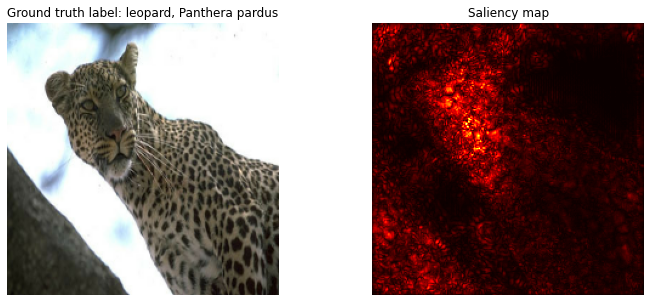

Model predictions:
[[('n02128385', 'leopard', 15.633688), ('n02124075', 'Egyptian_cat', 13.920521), ('n02130308', 'cheetah', 11.762303)]]


In [12]:
# Compute the saliency map for our img
sm, decoded_preds = saliency_map(vgg16, resized_img)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(resized_img.numpy() / 255.)
plt.axis('off')
plt.title("Ground truth label: {}".format(label))

plt.subplot(122)
plt.imshow(sm.numpy(), cmap='hot')
plt.axis('off')
plt.title("Saliency map")
plt.show()

print("Model predictions:\n{}".format(decoded_preds))

what I can see is that the face of the leopard is being highlighted by the saliency map! This makes sense, because there is alot of textures, edges and important features - which all infulence and eventually lead to the choice of prediction! Therefore it makes sence that the logit scores would be much higher in this location compared to the rest of the image!

## References 

<a class="anchor" id="Simonyan15"></a>
* Simonyan, K. & Zisserman, A. (2015), "Very Deep Convolutional Networks for Large-Scale Image Recognition", in *3rd International Conference on Learning Representations, (ICLR) 2015*, San Diego, CA, USA.